# Wavenumber spectral fitting of Jason-1/2/3 nadir data

Data pre-processed with `../../SWOT_NAust/NOTEBOOKS/play_w_jason_nadir.ipynb`


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy import signal

from nwatides.filtering import filt

import cartopy.crs as ccrs

In [2]:
ncfiles = [
    '/home/jupyter-mrayson/data/Altimetr//Jason-1_pass216_IndoAusBasin.nc',
    '/home/jupyter-mrayson/data/Altimetr//Jason-2_pass216_IndoAusBasin.nc',
    '/home/jupyter-mrayson/data/Altimetr//Jason-3_pass216_IndoAusBasin.nc'
]

ds = xr.open_mfdataset(ncfiles)
ds

<xarray.Dataset>
Dimensions:                            (satpass: 804, dist: 201)
Coordinates:
  * satpass                            (satpass) datetime64[ns] 2002-04-03T00...
  * dist                               (dist) float64 0.0 0.05315 ... 10.6 10.65
    lat                                (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    lon                                (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
Data variables: (12/66)
    surface_type                       (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    alt_echo_type                      (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    rad_surf_type                      (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    alt_quality_flag                   (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    rad_quality_flag                   (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    geophysical_quality_flag           (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    ...                                 ...
    sea_state_bias_mle3                (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    swh_ocean                          (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    swh_ocean_mle3                     (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    sig0_ocean                         (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    sig0_ocean_mle3                    (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
    wvf_main_class                     (satpass, dist) float64 dask.array<chunksize=(804, 201), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                      CF-1.1
    title:                            GDR - Reduced dataset
    institution:                      CNES
    source:                           radar altimeter
    history:                          2013-01-07 15:54:49 : Creation
    contact:                          CNES aviso@oceanobs.com, EUMETSAT ops@e...
    ...                               ...
    xref_utc_tai_data:                SMM_TUC_AXVCNE20120605_075702_19900101_...
    xref_radiometer_calibration:      AJ2_AL1_AXVJPL20080620_074625_20080620_...
    xref_gim_data:                    JA2_ION_AXPCNE20080711_073931_20080710_...
    xref_mog2d_data:                  SMM_MOG_AXVCNE20080731_184505_20080710_...
    ellipsoid_axis:                   6378136.3
    ellipsoid_flattening:             0.0033528131778969

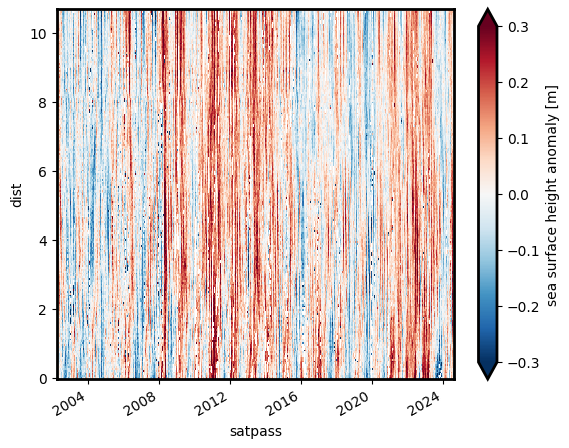

In [3]:
ds['ssha'].T.plot(vmin=-0.3, vmax=0.3, cmap='RdBu_r')

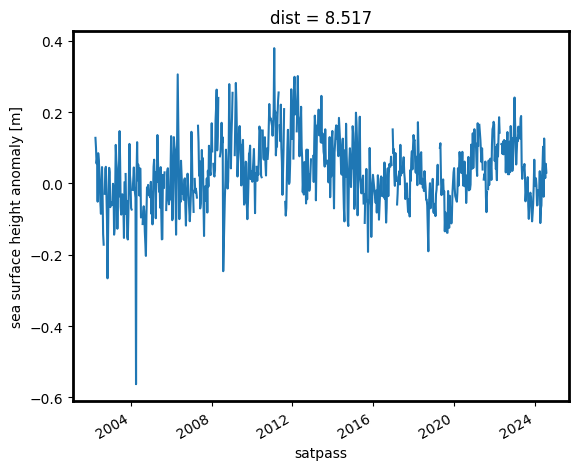

In [4]:
ds['ssha'].isel(dist=160).plot()

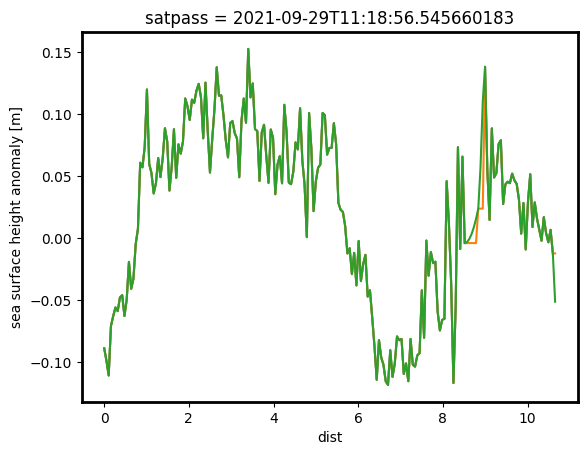

In [5]:
ds['ssha'].isel(satpass=700).plot()
ds['ssha'].isel(satpass=700).ffill('dist').plot()
ds['ssha'].isel(satpass=700).interpolate_na('dist', method='pchip').plot()


(101,)

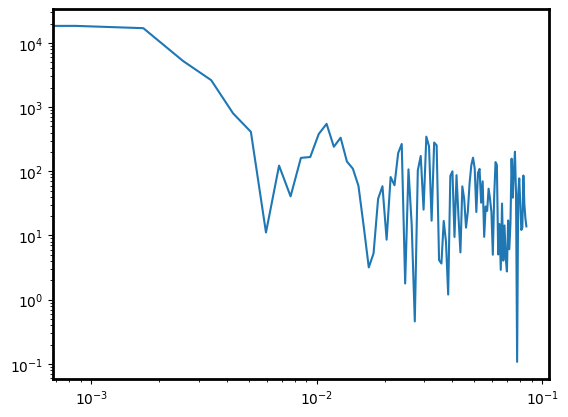

In [6]:
mypass = 700
ssha = ds['ssha'].isel(satpass=mypass).interpolate_na('dist', method='pchip').values
nn = ssha.shape[0]
dx = ds['dist'][1].values*110e3
# Calculate the power spectral density using Welch's method
ff, ss = signal.welch(ssha*100 , nfft=nn, nperseg=nn, noverlap=0,
                    detrend='linear', window='hann', fs=1e3 / dx)

plt.loglog(ff, ss)
ff.shape

In [7]:
numpass = 200 #ds['satpass'].shape[0]
ss = np.zeros((numpass, ff.shape[0]))

for mypass in range(numpass):
    ssha = ds['ssha'].isel(satpass=mypass+600).interpolate_na('dist', method='pchip').values
    nn = ssha.shape[0]
    dx = ds['dist'][1].values*110e3
    # Calculate the power spectral density using Welch's method
    ff, ss[mypass,:] = signal.welch(ssha*100 , nfft=nn, nperseg=nn, noverlap=0,
                        detrend='linear', window='hann', fs=1e3 / dx) 

(0.1, 100000.0)

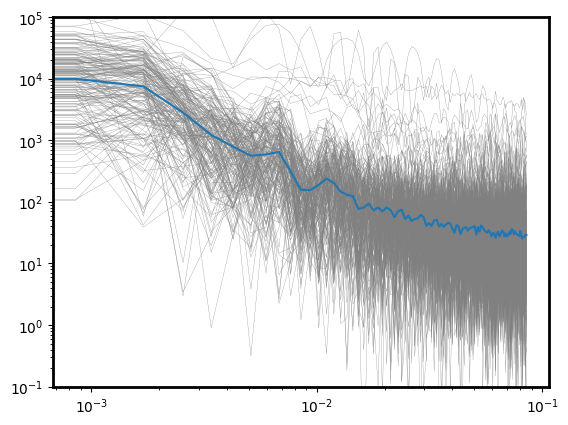

In [8]:
for ii in range(numpass):
    plt.loglog(ff, ss[ii,:],'0.5',lw=0.2)

# plt.loglog(ff, np.ss.mean(axis=0))
plt.loglog(ff, np.median(ss, axis=0))
plt.ylim(1e-1, 1e5)

In [9]:
2*np.pi/6e-3, 2*np.pi/2e-2

(1047.1975511965977, 314.1592653589793)

In [10]:
import matplotlib.pyplot as plt
import numpy as onp

from jax import numpy as np
from jax import random as jrandom
import jax.scipy.linalg as jla
import optax

# Local functions
import nonstat_itides_jax as nsjax

In [178]:
def itide_meso_gammaexp(x, xpr, params, ):

    eta_m, l_m, gam_m, eta_it, d_it, l_it, gam_it = params
    
    C = eta_m**2 * nsjax.gamma_exp(x, xpr, gam_m, l_m)
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta_it, d_it, l_it, gam_it))

    return C

def itide_D1D2_meso_gammaexp(x, xpr, params, gam_it = 2.):

    eta_m, l_m, gam_m, eta_it_D1, d_it_D1, l_it_D1, eta_it_D2, d_it_D2, l_it_D2 = params
    
    C = eta_m**2 * nsjax.gamma_exp(x, xpr, gam_m, l_m)
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta_it_D1, d_it_D1, l_it_D1, gam_it))
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta_it_D2, d_it_D2, l_it_D2, gam_it))

    return C

def itide_D0D1D2_meso_gammaexp(x, xpr, params, gam_it = 2.):

    eta_m, l_m, gam_m, eta_it_D0, d_it_D0, l_it_D0,\
        eta_it_D1, d_it_D1, l_it_D1, \
        eta_it_D2, d_it_D2, l_it_D2 = params
    
    C = eta_m**2 * nsjax.gamma_exp(x, xpr, gam_m, l_m)
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta_it_D0, d_it_D0, l_it_D0, gam_it))
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta_it_D1, d_it_D1, l_it_D1, gam_it))
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta_it_D2, d_it_D2, l_it_D2, gam_it))

    return C
    

def itide_meso_cosine(x, xpr, params, ):

    eta_m, l_m, gam_m, eta_it, l_it = params
    
    C = eta_m**2 * nsjax.gamma_exp(x, xpr, gam_m, l_m)
    C += eta_it**2 * nsjax.cosine(x, xpr, l_it)

    return C

In [246]:
###
# Name of the parametric covariance function

# True values of the covariance model parameters

eta_m = 0.15
l_m = 500.
gam_m = 1.0

eta_it_D0 = 0.01
d_it_D0 = 500.
l_it_D0 = 350.

eta_it_D1 = 0.01
d_it_D1 = 500.
l_it_D1 = 150.

eta_it_D2 = 0.01
d_it_D2 = 500.
l_it_D2 = 80.

gam_it = 1.5

# covfunc=nsjax.gamma_exp_1d
# covparams_guess = (eta_m, l_m, gam_m)

# covfunc = itide_meso_gammaexp
# covparams_guess = (eta_m, l_m, gam_m, eta_it_D1, d_it_D1, l_it_D1, gam_it )

# covfunc = itide_meso_cosine
# covparams_guess = (eta_m, l_m, gam_m, eta_it, l_it )

# covfunc = itide_D1D2_meso_gammaexp
# covparams_guess = (eta_m, l_m, gam_m, eta_it_D1, d_it_D1, l_it_D1, eta_it_D2, d_it_D2, l_it_D2 )

covfunc = itide_D0D1D2_meso_gammaexp
covparams_guess = (eta_m, l_m, gam_m, eta_it_D0, d_it_D0, l_it_D0,\
                   eta_it_D1, d_it_D1, l_it_D1, eta_it_D2, d_it_D2, l_it_D2 )

cov_kwargs = {}


# Frequency bands for fitting
fmin = 10e-4 # 5e-4
fmax = 2e-2 #
# fmax = 2.5e-3 #


###

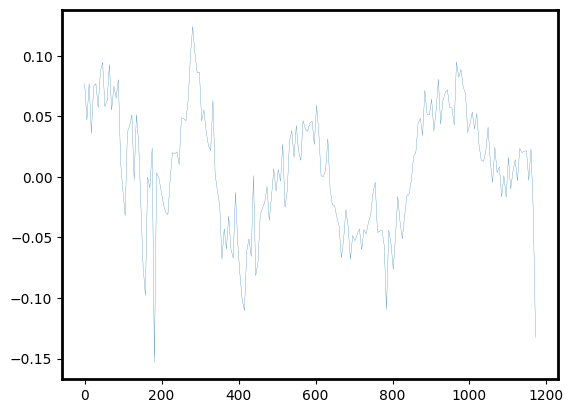

In [247]:
mypass = 702
y = ds['ssha'].isel(satpass=mypass).interpolate_na('dist', method='pchip').values
# X = ds['dist'].values*110 # km

#y = ds['alt_quality_flag'].isel(satpass=mypass).values#.interpolate_na('dist', method='pchip').values
#y = ds['ssha'].isel(satpass=mypass).values#.interpolate_na('dist', method='pchip').values
X = ds['dist'].values*110 # km

dt = X[1]
plt.plot(X,y, lw=0.2)
ff, ss = nsjax.periodogram(y, dt)
f, I = nsjax.periodogram(y, dt)


# # Use mean spectra
# numpass = 200 #ds['satpass'].shape[0]
# ss = onp.zeros((numpass, ff.shape[0]))

# for mypass in range(numpass):
#     y = ds['ssha'].isel(satpass=mypass+600).interpolate_na('dist', method='pchip').values
#     X = ds['dist'].values*110 # km
#     dt = X[1]
#     f, ss[mypass,:] = nsjax.periodogram(y, dt)

# I = np.median(ss, axis=0)


Text(0.5, 0, 'f [cpkm]')

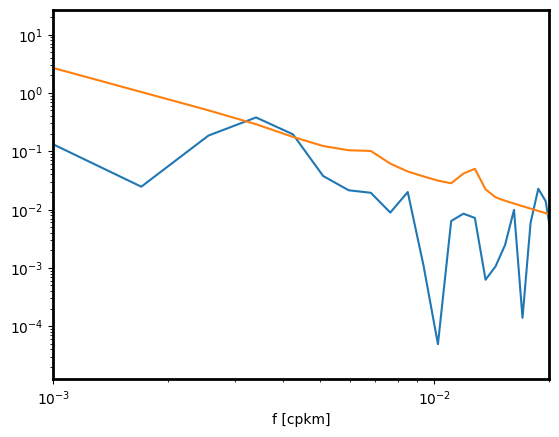

In [248]:
# Plot the periodogram of the time-series data and the parametric spectral profile
acf = covfunc(X, X[0], covparams_guess, **cov_kwargs)


# f = ff
# I = onp.median(ss, axis=0)
# bochner function does the discrete ifft
f_S, S = nsjax.bochner(acf, delta=dt)

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpkm]')

In [249]:
# Parameter estimation using jax
from nonstat_itides_jax import invlogit, logit
class CustomTransformer:
    def __init__(self,params):
        self.params = params

    def __call__(self):
        params_t = np.log(self.params)
        params_t = params_t.at[2].set(invlogit(self.params[2],scale=2))
        params_t = params_t.at[6].set(invlogit(self.params[6],scale=2))
        return params_t
        
    def out(self, tparams):
        params = np.exp(tparams)
        #params[2] = nsjax.logit(tparams[2],scale=2)
        #params[5] = nsjax.logit(tparams[5],scale=2)
        params = params.at[2].set(logit(tparams[2],scale=2))
        params = params.at[6].set(logit(tparams[6],scale=2))
        return params

params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-1),
                     verbose=True,
                    #transformer=CustomTransformer,
                    f=f,
                    I=I)
print(72*'#')
print('Estimated: ',params)

step 0, loss: -114.6921931313033
[1.35725613e-01 5.52585459e+02 1.10517092e+00 9.04837418e-03
 4.52418709e+02 3.16693096e+02 9.04837418e-03 5.52585459e+02
 1.65775638e+02 9.04837418e-03 5.52585459e+02 8.84136734e+01]
step 25, loss: -133.02263605378513
[8.08182350e-02 9.30995973e+02 6.89103122e-01 2.38623129e-02
 5.86938296e+02 2.76988859e+02 3.92845746e-03 6.23419201e+02
 5.07365512e+02 1.25743204e-03 2.02359868e+03 8.36383605e+01]
step 50, loss: -138.7710602195778
[4.98967863e-02 1.17754934e+03 2.64495842e-01 3.48871945e-02
 4.47558658e+02 2.86906251e+02 2.73231169e-03 2.47358692e+02
 4.42408932e+02 8.82023963e-04 2.29308535e+03 8.49734703e+01]
step 75, loss: -140.30418085132453
[4.63279466e-02 1.12327356e+03 1.33283639e-01 3.64339728e-02
 4.21336152e+02 2.86020538e+02 2.17896411e-03 8.49940139e+01
 3.99308701e+02 8.40782210e-04 2.42131805e+03 8.41746879e+01]
step 91, loss: -140.52858240616706
########################################################################
Estimated:  [4.7495

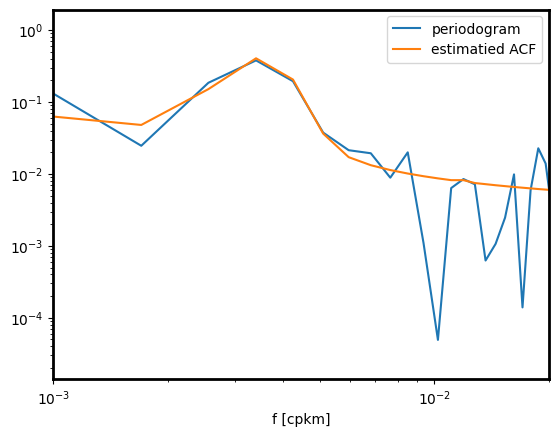

In [250]:
acf = covfunc(X, X[0], params, **cov_kwargs)
_, S_est = nsjax.bochner(acf, delta=dt)

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S_est)

plt.xlim(fmin, fmax)
plt.xlabel('f [cpkm]')
plt.legend(('periodogram','estimatied ACF'))

In [245]:
def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)

integral_timescale(nsjax.gamma_exp_1d, params[0:3])

/tmp/ipykernel_2487394/3036615209.py:6: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  return 1./covparams[0]**2 * np.trapz(acf, t)


Array(353.18431736, dtype=float64)

In [229]:
from tqdm import tqdm

In [230]:
mypass = 700

nparams = len(covparams_guess)
allparams = onp.zeros((nparams, 100))
plot = False

for ii in tqdm(range(100)):
    y = ds['ssha'].isel(satpass=mypass+ii).interpolate_na('dist', method='pchip').values
    X = ds['dist'].values*110 # km
    dt = X[1]
    f, I = nsjax.periodogram(y, dt)
    
    params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                          covfunc, covparams_guess,
                          fmin, fmax,
                          maxiter=1000,
                         opt= optax.adabelief(learning_rate=1e-1),
                         verbose=False,
                        #transformer=CustomTransformer,
                        f=f,
                        I=I)
    allparams[:,ii] = params

    if plot:
        acf = covfunc(X, X[0], params, **cov_kwargs)
        _, S_est = nsjax.bochner(acf, delta=dt)
        
        plt.figure()
        plt.loglog(f, I)
        plt.loglog(f_S,S_est)
        
        plt.xlim(fmin, fmax)
        plt.xlabel('f [cpkm]')
        plt.legend(('periodogram','estimatied ACF'))

  3%|▎         | 3/100 [00:02<01:26,  1.12it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(allparams[5,:])
plt.plot(allparams[8,:])
plt.plot(allparams[11,:])

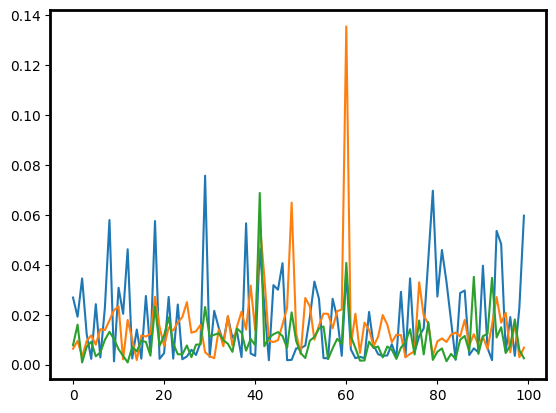

In [203]:
plt.plot(allparams[3,:])
plt.plot(allparams[6,:])
plt.plot(allparams[9,:])